# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 225kB/s]


In [4]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
   creating: inputs/
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
   creating: targets/
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [5]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [6]:
import numpy as np

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [7]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [8]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    delta_tolerance = 1e-8
    done = False
    while not done : 
        
        while True :
            delta = 0
            for state in states:
                j = values[state]
                action = policy[state]
                state_transition_probabs = taxienv.ride_probabilities(state,action)
                state_rewards = taxienv.ride_rewards(state,action)
                values[state] = sum([state_transition_probabs[i]*(state_rewards[i]+gamma*values[states[i]]) for i in range(len(states))])
                delta = max(delta, abs(values[state]-j))
            if delta < delta_tolerance : break

        done = True

        for state in states : 
            b = policy[state]
            possible_actions = taxienv.possible_actions(state)
            action_rewards = []
            for action in possible_actions:
                state_transition_probabs = taxienv.ride_probabilities(state,action)
                state_rewards = taxienv.ride_rewards(state,action)
                action_rewards.append(sum([state_transition_probabs[i]*(state_rewards[i]+gamma*values[states[i]]) for i in range(len(states))]))
            policy[state] = possible_actions[np.argmax(np.array(action_rewards))]
            if policy[state]!=b :
                done = False
        
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [9]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

In [10]:
policy_iteration_results, policy_iteration_extra_info = results.copy(), extra_info.copy()

In [11]:
"""
tar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()['policy_iteration']
for key in policy_iteration_results.keys():
    print(policy_iteration_results[key],tar[key])
"""

'\ntar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()[\'policy_iteration\']\nfor key in policy_iteration_results.keys():\n    print(policy_iteration_results[key],tar[key])\n'

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [12]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    done = False
    while not done : 
        for k in range(m) :
            new_values = values.copy()
            for state in states:
                action = policy[state]
                state_transition_probabs = taxienv.ride_probabilities(state,action)
                state_rewards = taxienv.ride_rewards(state,action)
                new_values[state] = sum([state_transition_probabs[i]*(state_rewards[i]+gamma*values[states[i]]) for i in range(len(states))])
            values = new_values.copy()
        done = True

        for state in states : 
            possible_actions = taxienv.possible_actions(state)
            action_rewards = []
            for action in possible_actions:
                state_transition_probabs = taxienv.ride_probabilities(state,action)
                state_rewards = taxienv.ride_rewards(state,action)
                action_rewards.append(sum([state_transition_probabs[i]*(state_rewards[i]+gamma*values[states[i]]) for i in range(len(states))]))
            if policy[state] != possible_actions[np.argmax(np.array(action_rewards))] : 
                done = False
            policy[state] = possible_actions[np.argmax(np.array(action_rewards))]
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [13]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

In [14]:
modified_policy_iteration_results, modified_policy_iteration_extra_info = results.copy(), extra_info.copy()

In [15]:
# modified_policy_iteration_results, policy_iteration_results

In [16]:
"""
tar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()['modifed_policy_iteration']
for key in modified_policy_iteration_results.keys():
    print(modified_policy_iteration_results[key],tar[key])
"""

'\ntar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()[\'modifed_policy_iteration\']\nfor key in modified_policy_iteration_results.keys():\n    print(modified_policy_iteration_results[key],tar[key])\n'

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [17]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    delta_tolerance = 1e-8
    num_iters = 0
    while True :
        num_iters+=1
        delta = 0
        new_values = values.copy()
        for state in states:
            possible_actions = taxienv.possible_actions(state)
            action_rewards = []
            for action in possible_actions:
                state_transition_probabs = taxienv.ride_probabilities(state,action)
                state_rewards = taxienv.ride_rewards(state,action)
                action_rewards.append(sum([state_transition_probabs[i]*(state_rewards[i]+gamma*values[states[i]]) for i in range(len(states))]))
            new_values[state] = max(action_rewards)
            policy[state] = possible_actions[np.argmax(np.array(action_rewards))]
            delta = max(delta, abs(values[state]-new_values[state]))
        values = new_values.copy()
        if delta < delta_tolerance : break
        

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"num_iters":num_iters}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [18]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

In [19]:
value_iteration_results, value_iteration_extra_info = results.copy(), extra_info.copy()

In [20]:
"""
tar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()['value_iteration']
for key in value_iteration_results.keys():
    print(value_iteration_results[key],tar[key])
"""

'\ntar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()[\'value_iteration\']\nfor key in value_iteration_results.keys():\n    print(value_iteration_results[key],tar[key])\n'

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [21]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    delta_tolerance = 1e-8
    num_iters = 0
    while True :
        num_iters+=1
        delta = 0
        for state in states:
            j = values[state]
            possible_actions = taxienv.possible_actions(state)
            action_rewards = []
            for action in possible_actions:
                state_transition_probabs = taxienv.ride_probabilities(state,action)
                state_rewards = taxienv.ride_rewards(state,action)
                action_rewards.append(sum([state_transition_probabs[i]*(state_rewards[i]+gamma*values[states[i]]) for i in range(len(states))]))
            values[state] = max(action_rewards)
            policy[state] = possible_actions[np.argmax(np.array(action_rewards))]
            delta = max(delta, abs(values[state]-j))
        if delta < delta_tolerance : break
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"num_iters":num_iters}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [22]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)

In [23]:
gs_value_iteration_results, gs_value_iteration_extra_info = results.copy(), extra_info.copy()

In [24]:
"""
tar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()['gauss_seidel_iteration']
for key in gs_value_iteration_results.keys():
    print(gs_value_iteration_results[key],tar[key])
"""

'\ntar = np.load("/content/targets/targets_base.npy",allow_pickle=True).item()[\'gauss_seidel_iteration\']\nfor key in gs_value_iteration_results.keys():\n    print(gs_value_iteration_results[key],tar[key])\n'

# Generate Results ✅

In [25]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [26]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [27]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

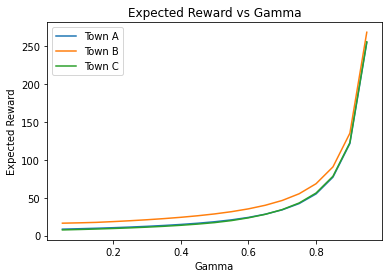

In [28]:
## Visualize policy iteration with multiple values of gamma
import matplotlib.pyplot as plt
gammas = np.arange(5, 100, 5)/100
for town in ['A','B','C']:
    plt.plot(gammas,[policy_iteration_results[gamma]['Expected Reward'][town] for gamma in gammas], label="Town {0}".format(town))
plt.legend()
plt.ylabel("Expected Reward")
plt.xlabel("Gamma")
plt.title("Expected Reward vs Gamma")
plt.show()

# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

As $\gamma$ increases, the expected reward also increases.  
This is expected as 1 - $\gamma$ is the probability of the car breaking down beyond which the taxi driver will be unable to make money. As $\gamma$ increases the probability of breakdown decreases thus giving higher expected earning/reward. 

## 1.b For modified policy itetaration, do you find any improvement if you choose m=10.

Yes there is an improvement when m increases. As m increases we move more towards a regular policy iteration system which is guaranteed to converge in a finite number of steps. Also we do not settle at any local minima with regular policy evaluation whereas in the case of low m-valued modified policy iteration, the algorithm arrives at the optimal policy but the reward is not maximized as the policy evaluation step is run only for m steps which may not be sufficient to reach the optimal value or reward, i.e. it settles at a local maxima. 

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

The Gauss Seidel method of Value Iteration converges faster as expected.

[]

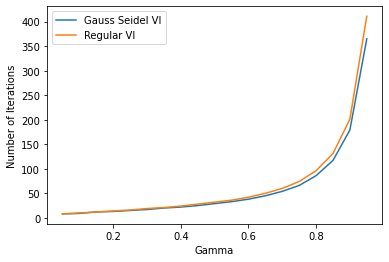

In [29]:
gammas = list(value_iteration_extra_info.keys())
gs_num_iters = [gs_value_iteration_extra_info[gamma]['num_iters'] for gamma in gammas]
vi_num_iters = [value_iteration_extra_info[gamma]['num_iters'] for gamma in gammas]
plt.plot(gammas,gs_num_iters,label='Gauss Seidel VI')
plt.plot(gammas,vi_num_iters,label='Regular VI')
plt.legend()
plt.ylabel("Number of Iterations")
plt.xlabel("Gamma")
plt.plot()

As we can see the number of iterations for the Regular Value Iteration case is always greater than or equal to the number of iterations in Gauss Seidel Method. 

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20IITM_Assignment_2_Taxi_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
